# Soccer Project Revamp Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

## Reading in Player DFs

In [2]:
#1481 + 114 = 1595 players in mySQL
gks = pd.read_csv("revamp_gk.csv")
gks.head()

,id,name,season,club,position,transfer_info,GA,GA90,SoTA,saves,save_pct,clean_sheets,clean_sheets_pct,pk_save_pct,PSxG,PSxG90,launch_cmp_pct,cross_stop_pct
0,1,Alisson,2018-2019,Liverpool,GK,62.5,22,0.58,96,74,77.1,21,55.3,0.0,27.2,0.29,41.5,4.2
1,2,Kepa Arrizabalaga,2018-2019,Chelsea,GK,80,39,1.08,121,81,68.6,14,38.9,50.0,36.5,0.29,49.6,3.8
2,3,Asmir Begovic,2018-2019,Bournemouth,GK,No transfer,47,1.96,104,59,56.7,5,20.8,0.0,34.5,0.32,39.3,6.6
3,4,Martin Dubravka,2018-2019,Newcastle United,GK,4,48,1.26,140,93,70.0,11,28.9,0.0,42.3,0.27,35.3,6.6
4,5,Ederson,2018-2019,Manchester City,GK,No transfer,23,0.61,81,58,76.5,20,52.6,0.0,23.3,0.25,41.0,6.7


In [3]:
players = pd.read_csv('revamp_players.csv')
players.head()

,id,name,season,club,position,transfer_info,goals,assists,crdY,crdR,...,clearances,errors,take_ons,take_on_pct,final_third_carries,fls_c,fls_d,ball_rec,aerials_won,aerials_pct
0,1,Patrick van Aanholt,2018-2019,Crystal Palace,LB,No transfer,3,2,3,0,...,91,2,22,52.4,69,12,14,216,10,45.5
1,2,Sergio Aguero,2018-2019,Manchester City,ST,No transfer,21,8,4,0,...,3,0,45,61.6,60,21,25,70,17,43.6
2,3,Nathan Ake,2018-2019,Bournemouth,CB,No transfer,4,0,3,0,...,241,0,3,60.0,18,28,21,182,86,56.6
3,4,Marc Albrighton,2018-2019,Leicester City,LW,No transfer,2,2,3,0,...,30,0,20,36.4,30,10,20,141,15,45.5
4,5,Toby Alderweireld,2018-2019,Tottenham Hotspur,CB,No transfer,0,0,3,0,...,175,0,1,50.0,25,10,1,193,54,53.5


In [4]:
print(gks.shape[0] + players.shape[0])

1600


## Creating Weights DF

In [5]:
#gk stats: GA, GA90, SoTA, Saves, Save%, CS, CS%, PK save%, PSxG, PSxG90, launch cmp%, cross stop% (12)
gk_stats_list = gks.columns.tolist()[6:]
gk_stats_list.append('position')
gk_weights = [5, 13, 3, 13, 13, 11, 9, 3, 9, 9, 6, 6, 'GK']
# print(len(gk_weights))
# print(sum(gk_weights))
gk_weights_df = pd.DataFrame(columns = gk_stats_list)
gk_weights_df.loc[len(gk_weights_df.index)] = gk_weights
gk_weights_df = gk_weights_df.set_index('position')
gk_weights_df

,GA,GA90,SoTA,saves,save_pct,clean_sheets,clean_sheets_pct,pk_save_pct,PSxG,PSxG90,launch_cmp_pct,cross_stop_pct
position,,,,,,,,,,,,
GK,5,13,3,13,13,11,9,3,9,9,6,6


In [6]:
player_stats_list = players.columns.tolist()[6:]
player_stats_list.append('position')
#need 37 cols + position
# FORMAT: Line 1 (goals, assists, crdY, crdR, xG, npxG, xA, progC, progP, progR)
# Line 2 (shots, SoT, g/shot, comp_passes, pass_cmp%, through balls, switches, crosses)
# Line 3 (sca, gca, tackles, tackle_win_pct, blocks, ints, clearances, errors, take_ons, take_on%)
# Line 4 (final_third_carries, fls_c, fls_d, ball_rec, aerials_won, aerials%)
fullback_weights = [5, 7, 2, 2, 2, 2, 7, 3, 3, 0,
                    2, 2, 0, 5, 5, 4, 4, 6,
                    2, 0, 5, 3, 3, 5, 2, 4, 0, 0,
                    0, 3, 3, 5, 2, 2, 'LB/RB']
cb_weights = [4, 2, 3, 2, 2, 2, 2, 0, 2, 0,
              2, 2, 0, 6, 6, 2, 2, 0,
              2, 0, 7, 7, 7, 7, 5, 5, 0, 0,
              0, 3, 2, 6, 5, 5, 'CB']
dm_weights = [5, 6, 2, 2, 3, 3, 4, 2, 2, 0,
              2, 2, 2, 5, 5, 3, 3, 2,
              3, 3, 6, 4, 2, 5, 2, 3, 2, 2,
              2, 2, 2, 5, 2, 2, 'DM']
am_weights = [7, 7, 2, 2, 4, 3, 4, 4, 7, 2,
              2, 2, 2, 2, 2, 5, 4, 5,
              6, 6, 0, 0, 0, 2, 0, 2, 2, 2,
              6, 2, 4, 2, 0, 0, 'AM']
winger_weights = [9, 8, 2, 2, 5, 5, 5, 7, 4, 4,
                  2, 2, 2, 2, 2, 3, 3, 4,
                  5, 5, 0, 0, 0, 0, 0, 2, 4, 4,
                  5, 2, 2, 0, 0, 0, 'LW/RW']
st_weights = [12, 5, 2, 2, 5, 5, 3, 4, 2, 5,
              5, 5, 5, 2, 2, 2, 2, 2,
              4, 4, 0, 0, 0, 0, 0, 0, 3, 3,
              4, 2, 4, 0, 3, 3, 'ST']

# print(sum(fullback_weights[:-1]))
# print(sum(cb_weights[:-1]))
# print(sum(dm_weights[:-1]))
# print(sum(am_weights[:-1]))
# print(sum(winger_weights[:-1]))
# print(sum(st_weights[:-1]))


player_weights_df = pd.DataFrame(columns = player_stats_list)
player_weights_df.loc[len(player_weights_df.index)] = fullback_weights
player_weights_df.loc[len(player_weights_df.index)] = cb_weights
player_weights_df.loc[len(player_weights_df.index)] = dm_weights
player_weights_df.loc[len(player_weights_df.index)] = am_weights
player_weights_df.loc[len(player_weights_df.index)] = winger_weights
player_weights_df.loc[len(player_weights_df.index)] = st_weights

player_weights_df.set_index('position', inplace = True)
player_weights_df

,goals,assists,crdY,crdR,xG,npxG,xA,progC,progP,progR,...,clearances,errors,take_ons,take_on_pct,final_third_carries,fls_c,fls_d,ball_rec,aerials_won,aerials_pct
position,,,,,,,,,,,,,,,,,,,,,
LB/RB,5,7,2,2,2,2,7,3,3,0,...,2,4,0,0,0,3,3,5,2,2
CB,4,2,3,2,2,2,2,0,2,0,...,5,5,0,0,0,3,2,6,5,5
DM,5,6,2,2,3,3,4,2,2,0,...,2,3,2,2,2,2,2,5,2,2
AM,7,7,2,2,4,3,4,4,7,2,...,0,2,2,2,6,2,4,2,0,0
LW/RW,9,8,2,2,5,5,5,7,4,4,...,0,2,4,4,5,2,2,0,0,0
ST,12,5,2,2,5,5,3,4,2,5,...,0,0,3,3,4,2,4,0,3,3


## Creating Single Player DF with Season Scores

In [7]:
# Getting GK and Player Stats (including Negative Stats)
gk_stats_list = gk_weights_df.columns.tolist()
player_stats = player_weights_df.columns.tolist()

negative_gk_stats = ['GA', 'GA90', 'SoTA', 'PSxG', 'PsxG90']
negative_stats = ['crdY', 'crdR', 'errors']

In [8]:
#checked for no noticeable differences between seasons      avgs.iloc[:, 30:40]
gk_avgs = gks.groupby('season').mean().round(2)

fullback_df = players[(players['position'] == 'LB') | (players['position'] == 'RB')]
fullback_avgs = fullback_df.groupby('season').mean().round(2)

cb_df = players[(players['position'] == 'CB')]
cb_avgs = cb_df.groupby('season').mean().round(2)

dm_df = players[(players['position'] == 'DM')]
dm_avgs = dm_df.groupby('season').mean().round(2)

am_df = players[(players['position'] == 'AM')]
am_avgs = am_df.groupby('season').mean().round(2)

winger_df = players[(players['position'] == 'LW') | (players['position'] == 'RW')]
winger_avgs = winger_df.groupby('season').mean().round(2)

st_df = players[(players['position'] == 'ST')]
st_avgs = st_df.groupby('season').mean().round(2)

### Goalkeepers

In [9]:
def get_gk_score(row):
    season_score = 0
    for stat in gk_stats_list:
        season = row['season']
        if stat not in negative_gk_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(gks[gks['season'] == season][stat], row[stat]) * gk_weights_df.iloc[0][stat]
        else:
            stat_score = (100 - stats.percentileofscore(gks[gks['season'] == season][stat], row[stat])) * gk_weights_df.iloc[0][stat]
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000
    # Then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

gks['Season Score'] = gks.apply(get_gk_score, axis = 1)

In [10]:
# 114 expected : 114 found
gks[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
0,Alisson,2018-2019,Liverpool,GK,62.5,78.20
1,Kepa Arrizabalaga,2018-2019,Chelsea,GK,80,67.41


In [11]:
gks.groupby('season')['Season Score'].mean()

season
2018-2019    50.909545
2019-2020    50.833750
2020-2021    50.909545
2021-2022    50.909545
2022-2023    50.832500
Name: Season Score, dtype: float64

### Fullbacks

In [12]:
def get_fullback_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(fullback_df[fullback_df['season'] == season][stat], row[stat]) * player_weights_df.loc['LB/RB'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(fullback_df[fullback_df['season'] == season][stat], row[stat])) * player_weights_df.loc['LB/RB'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

fullback_df['Season Score'] = fullback_df.apply(get_fullback_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/3993896975.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullback_df['Season Score'] = fullback_df.apply(get_fullback_score, axis = 1)


In [13]:
# 284 Expected : 284 found
fullback_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
0,Patrick van Aanholt,2018-2019,Crystal Palace,LB,No transfer,71.82
5,Trent Alexander-Arnold,2018-2019,Liverpool,RB,No transfer,73.57


In [14]:
fullback_df.groupby('season')['Season Score'].mean()

season
2018-2019    50.711695
2019-2020    50.823922
2020-2021    50.823333
2021-2022    50.677258
2022-2023    50.688197
Name: Season Score, dtype: float64

### Center Backs

In [15]:
def get_cb_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(cb_df[cb_df['season'] == season][stat], row[stat]) * player_weights_df.loc['CB'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(cb_df[cb_df['season'] == season][stat], row[stat])) * player_weights_df.loc['CB'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

cb_df['Season Score'] = cb_df.apply(get_cb_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/544071069.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb_df['Season Score'] = cb_df.apply(get_cb_score, axis = 1)


In [16]:
# 307 expected : 307 found
cb_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
2,Nathan Ake,2018-2019,Bournemouth,CB,No transfer,74.31
4,Toby Alderweireld,2018-2019,Tottenham Hotspur,CB,No transfer,56.30


In [17]:
cb_df.groupby('season')['Season Score'].mean()

season
2018-2019    50.655246
2019-2020    50.634762
2020-2021    50.615692
2021-2022    50.677966
2022-2023    50.678475
Name: Season Score, dtype: float64

### Defensive Midfielders

In [18]:
def get_dm_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(dm_df[dm_df['season'] == season][stat], row[stat]) * player_weights_df.loc['DM'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(dm_df[dm_df['season'] == season][stat], row[stat])) * player_weights_df.loc['DM'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

dm_df['Season Score'] = dm_df.apply(get_dm_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/1314610390.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm_df['Season Score'] = dm_df.apply(get_dm_score, axis = 1)


In [19]:
# 267 expected : 257 found
dm_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
18,Juninho Bacuna,2018-2019,Huddersfield Town,DM,2.5,39.25
31,Bernard,2018-2019,Everton,DM,free,52.27


In [20]:
dm_df.groupby('season')['Season Score'].mean()

season
2018-2019    50.811321
2019-2020    50.728983
2020-2021    50.754035
2021-2022    50.827115
2022-2023    50.935000
Name: Season Score, dtype: float64

### Attacking Midfielder

In [21]:
def get_am_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(am_df[am_df['season'] == season][stat], row[stat]) * player_weights_df.loc['AM'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(am_df[am_df['season'] == season][stat], row[stat])) * player_weights_df.loc['AM'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

am_df['Season Score'] = am_df.apply(get_am_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/4084630520.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df['Season Score'] = am_df.apply(get_am_score, axis = 1)


In [22]:
# 197 expected : 197 found
am_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
6,Dele Alli,2018-2019,Tottenham Hotspur,AM,No transfer,53.33
10,Stuart Armstrong,2018-2019,Southampton,AM,7.95,39.94


In [23]:
am_df.groupby('season')['Season Score'].mean()

season
2018-2019    51.127949
2019-2020    51.023023
2020-2021    51.157632
2021-2022    51.332727
2022-2023    51.000455
Name: Season Score, dtype: float64

### Wingers

In [24]:
def get_winger_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(winger_df[winger_df['season'] == season][stat], row[stat]) * player_weights_df.loc['LW/RW'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(winger_df[winger_df['season'] == season][stat], row[stat])) * player_weights_df.loc['LW/RW'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

winger_df['Season Score'] = winger_df.apply(get_winger_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/1069411482.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winger_df['Season Score'] = winger_df.apply(get_winger_score, axis = 1)


In [25]:
# 243 expected : 243 found
winger_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
3,Marc Albrighton,2018-2019,Leicester City,LW,No transfer,36.47
8,Felipe Anderson,2018-2019,West Ham United,RW,38,76.97


In [26]:
winger_df.groupby('season')['Season Score'].mean()

season
2018-2019    50.880000
2019-2020    51.073902
2020-2021    50.897551
2021-2022    50.846154
2022-2023    50.862745
Name: Season Score, dtype: float64

### Strikers

In [27]:
def get_st_score(row):
    season_score = 0
    for stat in player_stats:
        season = row['season']
        if stat not in negative_stats:
            #percentileofscore gets score (0-100) then multiply by weights and add up
            stat_score = stats.percentileofscore(st_df[st_df['season'] == season][stat], row[stat]) * player_weights_df.loc['ST'][stat]
        else:
            stat_score = (100 - stats.percentileofscore(st_df[st_df['season'] == season][stat], row[stat])) * player_weights_df.loc['ST'][stat]    
        season_score += stat_score
    # highest possible is 10,000.... Avg is 5,000 then divide to get a final score between 0 and 100
    return (round((season_score / 100), 2)) 

st_df['Season Score'] = st_df.apply(get_st_score, axis = 1)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/3763709698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_df['Season Score'] = st_df.apply(get_st_score, axis = 1)


In [28]:
# 188 expected : 188 found
st_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']].head(2)#.sort_values('Season Score', ascending = False).head()

,name,season,club,position,transfer_info,Season Score
1,Sergio Aguero,2018-2019,Manchester City,ST,No transfer,83.25
9,Michail Antonio,2018-2019,West Ham United,ST,No transfer,64.86


In [29]:
st_df.groupby('season')['Season Score'].mean()

season
2018-2019    51.277500
2019-2020    51.178718
2020-2021    51.210000
2021-2022    51.150000
2022-2023    51.314000
Name: Season Score, dtype: float64

## Combining Positions into Large Player DF

In [30]:
player_score_df = pd.DataFrame(columns = ['name', 'season', 'club', 'position', 'transfer_info', 'Season Score'])
player_score_df = player_score_df.append(gks[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(fullback_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(cb_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(dm_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(am_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(winger_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])
player_score_df = player_score_df.append(st_df[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']])

player_score_df = player_score_df.reset_index()[['name', 'season', 'club', 'position', 'transfer_info', 'Season Score']]
player_score_df.head()

,name,season,club,position,transfer_info,Season Score
0,Alisson,2018-2019,Liverpool,GK,62.5,78.20
1,Kepa Arrizabalaga,2018-2019,Chelsea,GK,80,67.41
2,Asmir Begovic,2018-2019,Bournemouth,GK,No transfer,38.73
3,Martin Dubravka,2018-2019,Newcastle United,GK,4,56.68
4,Ederson,2018-2019,Manchester City,GK,No transfer,70.02


In [31]:
# Checks that all teams have 16 players for each season
player_score_df.groupby(['season', 'club']).count().sort_values('name')

name  position  transfer_info  Season Score
season    club                                                                
2018-2019 Arsenal                    16        16             16            16
2021-2022 Manchester United          16        16             16            16
          Manchester City            16        16             16            16
          Liverpool                  16        16             16            16
          Leicester City             16        16             16            16
...                                 ...       ...            ...           ...
2019-2020 Leicester City             16        16             16            16
          Everton                    16        16             16            16
          Crystal Palace             16        16             16            16
          Tottenham Hotspur          16        16             16            16
2022-2023 Wolverhampton Wanderers    16        16             16            16

[100 rows x 4 columns]

# Player Analysis

### Getting Transfers/Loans($)/Loans(Free)/Frees DF

In [32]:
transactions = player_score_df[player_score_df['transfer_info'] != 'No transfer']
# shape is (396, 6)

In [33]:
# FREE LOANS (40 Players)
loan_free = transactions[transactions['transfer_info'] == 'loan']
loan_free.head(2)

,name,season,club,position,transfer_info,Season Score
19,Sergio Rico,2018-2019,Fulham,GK,loan,34.23
34,Dean Henderson,2019-2020,Sheffield United,GK,loan,70.08


In [34]:
# FREE TRANSFERS (32 Players)
three_left = transactions.drop(loan_free.index)
free = three_left[three_left['transfer_info'] == 'free']
free.head(2)

,name,season,club,position,transfer_info,Season Score
9,Vicente Guaita,2018-2019,Crystal Palace,GK,free,56.82
22,Adrian,2019-2020,Liverpool,GK,free,46.90


In [35]:
# LOAN FEES (29 Players)
two_left = three_left.drop(free.index)
loan_fees = two_left[two_left['transfer_info'].str.split(" ").str.len() == 2]

In [36]:
def get_loan_fee(transfer_info):
    part1 = transfer_info.split(" ")[0]
    part2 = transfer_info.split(" ")[1]
    if part1 != 'loan':
        try:
            loan_fee = float(part1)
        except:
            loan_fee = float(part1[:-1]) / 1000
    elif part2 != 'loan':
        try:
            loan_fee = float(part2)
        except:
            loan_fee = float(part2[:-1]) / 1000
    return loan_fee

loan_fees['loan_fee'] = loan_fees['transfer_info'].apply(get_loan_fee)
loan_fees.head(2)

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/2830876989.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_fees['loan_fee'] = loan_fees['transfer_info'].apply(get_loan_fee)


,name,season,club,position,transfer_info,Season Score,loan_fee
43,Pepe Reina,2019-2020,Aston Villa,GK,400k loan,38.02,0.4
72,Alvaro Fernandez,2021-2022,Brentford,GK,1 loan,33.07,1.0


In [37]:
# TRANSFERS (294 Players)
transfers = two_left.drop(loan_fees.index)
# Vitaliy Mykolenko 2022-23 Everton -- NaN --> Dropped from DF (no transfer)
transfers = transfers.drop(369)
# Said Benrahma 2020-21 West Ham -- 4.4 loan + 23.1 --> 27.5
transfers.loc[1266, 'transfer_info'] = 27.5
# Callum Robinson 2020-21 West Brom -- part of swap, estimate 5.5 --> 5.5
transfers.loc[1514, 'transfer_info'] = 5.5

In [38]:
transfers['transfer_info'] = transfers['transfer_info'].apply(lambda x: float(x))
transfers.head(2)

,name,season,club,position,transfer_info,Season Score
0,Alisson,2018-2019,Liverpool,GK,62.5,78.20
1,Kepa Arrizabalaga,2018-2019,Chelsea,GK,80.0,67.41


### Calculating Transfer Scores for Transfers, Frees, and Loan Fees

In [39]:
def calculate_multi_year_score(row):
    future_df = player_score_df[(player_score_df['name'] == row['name']) & (player_score_df['club'] == row['club']) & (player_score_df['season'] > row['season'])]
    if future_df.shape[0] != 0:
        future_score = round(future_df['Season Score'].sum(), 2)
    else:
        future_score = 0
    multi_year_score = row['Season Score'] + future_score
    return multi_year_score

def calculate_transfer_score(row):
    multi_season_score_pct = stats.percentileofscore(transfers[transfers['season'] == row['season']]['Multi Season Score'], row['Multi Season Score'])
    transfer_fee_pct = stats.percentileofscore(transfers['transfer_info'], row['transfer_info'])
    transfer_score = round((multi_season_score_pct - transfer_fee_pct) / transfer_fee_pct, 2)
    return transfer_score

def calculate_loan_score(row):
    season_score_pct = stats.percentileofscore(loan_fees['Season Score'], row['Season Score'])
    loan_fee_pct = stats.percentileofscore(loan_fees['loan_fee'], row['loan_fee'])
    loan_score = round((season_score_pct - loan_fee_pct) / loan_fee_pct, 2)
    return loan_score

# percentie for transfer fee and percentile for multi-season score
# multi season score pct - transfer fee pct / transfer fee pct

In [40]:
free['Multi Season Score'] = free.apply(calculate_multi_year_score, axis = 1)
transfers['Multi Season Score'] = transfers.apply(calculate_multi_year_score, axis = 1)
transfers['Transfer Score'] = transfers.apply(calculate_transfer_score, axis = 1)
loan_fees['Loan Score'] = loan_fees.apply(calculate_loan_score, axis = 1)
#transfers[transfers['transfer_info'] > 20].sort_values(['Transfer Score'], ascending = False)[:20]
#loan_fees.sort_values(['Loan Score'])

C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/123441485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free['Multi Season Score'] = free.apply(calculate_multi_year_score, axis = 1)
C:\Users\zeism\AppData\Local\Temp/ipykernel_20188/123441485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_fees['Loan Score'] = loan_fees.apply(calculate_loan_score, axis = 1)


### Ranking Players Each Year in Each Category

In [41]:
# LOANS (FREE) -- Rank by season score
loan_free.groupby('season').get_group('2018-2019').sort_values(['Season Score'], ascending = False)[:3]
loan_free.groupby('season').get_group('2019-2020').sort_values(['Season Score'], ascending = False)[:3]
loan_free.groupby('season').get_group('2020-2021').sort_values(['Season Score'], ascending = False)[:3]
loan_free.groupby('season').get_group('2021-2022').sort_values(['Season Score'], ascending = False)[:3]
loan_free.groupby('season').get_group('2022-2023').sort_values(['Season Score'], ascending = False)[:3]

,name,season,club,position,transfer_info,Season Score
679,Clement Lenglet,2022-2023,Tottenham Hotspur,CB,loan,48.63
98,Dean Henderson,2022-2023,Nottingham Forest,GK,loan,47.58
657,Levi Colwill,2022-2023,Brighton & Hove Albion,CB,loan,36.81


In [42]:
# LOANS (PAID) -- Rank by loan_score
loan_fees.groupby('season').get_group('2018-2019').sort_values(['Loan Score'], ascending = False)[:3]
loan_fees.groupby('season').get_group('2019-2020').sort_values(['Loan Score'], ascending = False)[:3]
loan_fees.groupby('season').get_group('2020-2021').sort_values(['Loan Score'], ascending = False)[:3]
loan_fees.groupby('season').get_group('2021-2022').sort_values(['Loan Score'], ascending = False)[:3]
loan_fees.groupby('season').get_group('2022-2023').sort_values(['Loan Score'], ascending = False)[:3]

,name,season,club,position,transfer_info,Season Score,loan_fee,Loan Score
375,Pedro Porro,2022-2023,Tottenham Hotspur,RB,loan 5,51.54,5.0,-0.11
365,Renan Lodi,2022-2023,Nottingham Forest,LB,loan 5,48.45,5.0,-0.28
1374,Joao Felix,2022-2023,Chelsea,RW,loan 11,30.78,11.0,-0.79


In [43]:
# FREE TRANSFERS -- Rank by multi-year score
free.groupby('season').get_group('2018-2019').sort_values(['Multi Season Score'], ascending = False)[:3]
free.groupby('season').get_group('2019-2020').sort_values(['Multi Season Score'], ascending = False)[:3]
free.groupby('season').get_group('2020-2021').sort_values(['Multi Season Score'], ascending = False)[:3]
free.groupby('season').get_group('2021-2022').sort_values(['Multi Season Score'], ascending = False)[:3]
free.groupby('season').get_group('2022-2023').sort_values(['Multi Season Score'], ascending = False)[:3]

,name,season,club,position,transfer_info,Season Score,Multi Season Score
698,James Tarkowski,2022-2023,Everton,CB,free,73.41,73.41
685,Ben Mee,2022-2023,Brentford,CB,free,68.77,68.77
1408,Willian,2022-2023,Fulham,LW,free,65.23,65.23


In [44]:
# TRANSFERS (CHEAP) -- Rank by transfer_score
transfers[transfers['transfer_info'] < 10].groupby('season').get_group('2018-2019').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] < 10].groupby('season').get_group('2019-2020').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] < 10].groupby('season').get_group('2020-2021').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] < 10].groupby('season').get_group('2021-2022').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] < 10].groupby('season').get_group('2022-2023').sort_values(['Transfer Score'], ascending = False)[:5]

,name,season,club,position,transfer_info,Season Score,Multi Season Score,Transfer Score
666,Felipe,2022-2023,Nottingham Forest,CB,2.3,48.28,48.28,14.71
100,Bernd Leno,2022-2023,Fulham,GK,3.6,52.12,52.12,7.59
937,Idrissa Gana Gueye,2022-2023,Everton,DM,4.0,55.95,55.95,6.14
1161,Andreas Pereira,2022-2023,Fulham,AM,9.5,61.49,61.49,2.45
1376,Degnand Gnonto,2022-2023,Leeds United,LW,4.5,33.95,33.95,1.26


In [45]:
# TRANSFERS (MID) -- Rank by transfer_score
transfers[(transfers['transfer_info'] > 10) & (transfers['transfer_info'] <25)].groupby('season').get_group('2018-2019').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[(transfers['transfer_info'] > 10) & (transfers['transfer_info'] <25)].groupby('season').get_group('2019-2020').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[(transfers['transfer_info'] > 10) & (transfers['transfer_info'] <25)].groupby('season').get_group('2020-2021').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[(transfers['transfer_info'] > 10) & (transfers['transfer_info'] <25)].groupby('season').get_group('2021-2022').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[(transfers['transfer_info'] > 10) & (transfers['transfer_info'] <25)].groupby('season').get_group('2022-2023').sort_values(['Transfer Score'], ascending = False)[:5]

,name,season,club,position,transfer_info,Season Score,Multi Season Score,Transfer Score
107,Nick Pope,2022-2023,Newcastle United,GK,11.5,71.69,71.69,2.14
652,Armel Bella Kotchap,2022-2023,Southampton,CB,11.0,54.51,54.51,1.33
963,Marc Roca,2022-2023,Leeds United,DM,12.0,57.90,57.90,1.29
1404,Marcus Tavernier,2022-2023,Bournemouth,RW,11.9,52.25,52.25,0.94
359,Pervis Estupinan,2022-2023,Brighton & Hove Albion,LB,17.8,79.15,79.15,0.86


In [46]:
# TRANSFERS (EXPENSIVE) -- Rank by transfer_score
transfers[transfers['transfer_info'] > 25].groupby('season').get_group('2018-2019').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] > 25].groupby('season').get_group('2019-2020').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] > 25].groupby('season').get_group('2020-2021').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] > 25].groupby('season').get_group('2021-2022').sort_values(['Transfer Score'], ascending = False)[:5]
transfers[transfers['transfer_info'] > 25].groupby('season').get_group('2022-2023').sort_values(['Transfer Score'], ascending = False)[:5]

,name,season,club,position,transfer_info,Season Score,Multi Season Score,Transfer Score
1142,Morgan Gibbs-White,2022-2023,Nottingham Forest,AM,29.5,70.56,70.56,0.26
1583,Gabriel Jesus,2022-2023,Arsenal,ST,52.2,80.24,80.24,0.11
653,Sven Botman,2022-2023,Newcastle United,CB,37.0,69.36,69.36,0.11
1578,Erling Haaland,2022-2023,Manchester City,ST,60.0,80.09,80.09,0.06
397,Oleksandr Zinchenko,2022-2023,Arsenal,LB,35.0,65.38,65.38,0.05


# Team Analysis

### Getting Team Scores

In [47]:
team_scores = player_score_df.groupby(['season', 'club'])['Season Score'].sum()
team_df = pd.DataFrame(team_scores)
team_df = team_df.reset_index()

In [48]:
# Get Predicted Table for Each Year
team_df.groupby('season').get_group('2018-2019').sort_values(['Season Score'], ascending = False)
team_df.groupby('season').get_group('2019-2020').sort_values(['Season Score'], ascending = False)
team_df.groupby('season').get_group('2020-2021').sort_values(['Season Score'], ascending = False)
team_df.groupby('season').get_group('2021-2022').sort_values(['Season Score'], ascending = False)
team_df.groupby('season').get_group('2022-2023').sort_values(['Season Score'], ascending = False)

,season,club,Season Score
92,2022-2023,Manchester City,995.67
84,2022-2023,Brighton & Hove Albion,961.38
80,2022-2023,Arsenal,945.15
94,2022-2023,Newcastle United,907.71
97,2022-2023,Tottenham Hotspur,905.56
93,2022-2023,Manchester United,894.60
91,2022-2023,Liverpool,871.68
81,2022-2023,Aston Villa,858.91
88,2022-2023,Fulham,808.32
86,2022-2023,Crystal Palace,806.21


In [ ]:
#player_score_df.groupby(['season', 'club']).get_group(('2021-2022', 'Newcastle United'))

### Testing the Predicted Table

In [49]:
# Lists are hand-made showing distance from correct table position and predicted
# 2018-2019 season improved by 24 total (42 vs 18)
# 2019-20 season improved by 27 total (81 vs 54)
# 2020-21 season got worse by 2 (58 vs 60)
# 2021-22 season improved by 20 (60 vs 40)
lst = [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 5, 0, 0, 4, 1, 1, 0,
      1, 2, 2, 1, 2, 0, 0, 7, 3, 6, 2, 1, 4, 6, 1, 6, 1, 1, 1, 7,
      0, 0, 1, 5, 2, 4, 4, 3, 3, 6, 3, 3, 0, 4, 8, 1, 3, 2, 0, 8,
      0, 0, 0, 0, 1, 1, 0, 6, 0, 5, 1, 1, 5, 3, 3, 2, 1, 1, 1, 9,
      0, 4, 1, 0, 3, 3, 2, 1, 1, 1, 1, 2, 4, 4, 4, 1, 2, 2, 3, 7]
lst2 = [0, 0, 2, 1, 1, 2, 0, 2, 2, 5, 2, 2, 5, 0, 4, 1, 2, 8, 3, 0,
       1, 1, 1, 1, 2, 9, 9, 9, 2, 4, 1, 9, 6, 4, 1, 6, 9, 0, 6, 0,
       1, 1, 7, 2, 1, 5, 2, 0, 4, 7, 8, 5, 2, 0, 1, 2, 4, 6, 0, 0,
       1, 1, 6, 1, 2, 10, 1, 4, 4, 5, 4, 4, 1, 0, 5, 2, 0, 1, 8, 0]

testing_df = pd.DataFrame(lst, columns = ['new'])
testing_df['old'] = pd.Series(lst2)
testing_df['old'].describe()
#testing_df['new'].describe()

count    80.000000
mean      3.012500
std       2.826161
min       0.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      10.000000
Name: old, dtype: float64

### Getting Team Transfer Scores

In [50]:
# Score / Total Money Spent for each team/season
# Score probably comprises of the 4 player transfer categories
def get_transfer_score(row):
    # No meaningful transfers
    if [row['season'], row['club']] == ['2018-2019', 'Tottenham Hotspur']:
        transfer_score = 0
    else:
        transfer_score = transactions.groupby(['season', 'club']).get_group((row['season'], row['club']))['Season Score'].sum()
    return transfer_score

transfer_scores = team_df.apply(get_transfer_score, axis = 1)
team_df['Transfer Score'] = transfer_scores

In [51]:
def get_total_spent(row):
    try:
        transfer_money = transfers.groupby(['season', 'club']).get_group((row['season'], row['club']))['transfer_info'].sum()
    except:
        transfer_money = 0.0
    try:
        loan_money = loan_fees.groupby(['season', 'club']).get_group((row['season'], row['club']))['loan_fee'].sum()
    except:
        loan_money = 0.0
    return transfer_money + loan_money

total_spent = team_df.apply(get_total_spent, axis = 1)
team_df['Total Spent'] = total_spent

In [52]:
def get_scores_per_eur(row):
    try:
        score_per_eur = round((row['Transfer Score'] / row['Total Spent']), 2)
    except:
        score_per_eur = round((row['Transfer Score'] / 1), 2)
    return score_per_eur

scores_per_eur = team_df.apply(get_scores_per_eur, axis = 1)
team_df['Score per eur'] = scores_per_eur
team_df.sort_values('Score per eur', ascending = False)

,season,club,Season Score,Transfer Score,Total Spent,Score per eur
42,2020-2021,Brighton & Hove Albion,830.28,136.92,1.00,136.92
29,2019-2020,Liverpool,948.21,46.90,0.00,46.90
47,2020-2021,Fulham,774.18,547.99,21.15,25.91
26,2019-2020,Crystal Palace,745.29,83.48,3.30,25.30
33,2019-2020,Norwich City,681.31,18.28,0.00,18.28
...,...,...,...,...,...,...
91,2022-2023,Liverpool,871.68,96.93,127.00,0.76
71,2021-2022,Manchester City,1056.98,58.41,117.50,0.50
65,2021-2022,Chelsea,960.07,48.81,113.00,0.43
99,2022-2023,Wolverhampton Wanderers,632.98,17.86,50.00,0.36


In [53]:
def get_score_per_eur_log(row):
    try:
        log = round(math.log(row['Score per eur']), 4)
    except:
        log = 0.0
    return log
logs = team_df.apply(get_score_per_eur_log, axis = 1)
team_df['Log Scores'] = logs
team_df

,season,club,Season Score,Transfer Score,Total Spent,Score per eur,Log Scores
0,2018-2019,Arsenal,916.05,206.20,77.65,2.66,0.9783
1,2018-2019,Bournemouth,773.81,138.20,41.80,3.31,1.1969
2,2018-2019,Brighton & Hove Albion,675.59,131.21,52.80,2.49,0.9123
3,2018-2019,Burnley,733.05,37.95,3.90,9.73,2.2752
4,2018-2019,Cardiff City,672.42,178.15,22.75,7.83,2.0580
...,...,...,...,...,...,...,...
95,2022-2023,Nottingham Forest,667.16,491.55,114.10,4.31,1.4609
96,2022-2023,Southampton,686.32,184.46,54.36,3.39,1.2208
97,2022-2023,Tottenham Hotspur,905.56,305.24,113.00,2.70,0.9933
98,2022-2023,West Ham United,796.50,200.49,133.85,1.50,0.4055


<AxesSubplot:title={'center':'Transfer Performance by Club'}, xlabel='Club', ylabel='log(Performance)'>

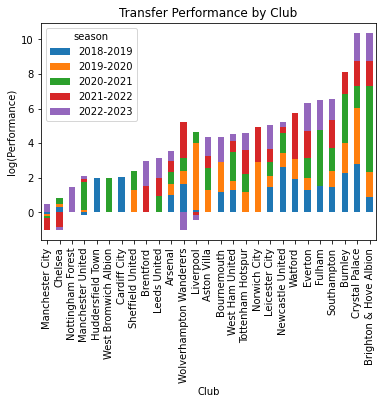

In [55]:
# ALTERNATE GRAPH (NOT USED) THAT USES THE NATURAL LOG INSTEAD OF A TYPICAL LOG

alt_df = team_df.groupby(['club', 'season'])['Log Scores'].sum().unstack('season')
alt_df['Sum'] = alt_df.sum(axis = 1)
alt_df = alt_df.sort_values(by = 'Sum')
alt_df.drop(columns = 'Sum', inplace = True)

alt_df.plot(kind = 'bar', stacked = True,
            title = 'Transfer Performance by Club', xlabel = 'Club', ylabel = 'log(Performance)')

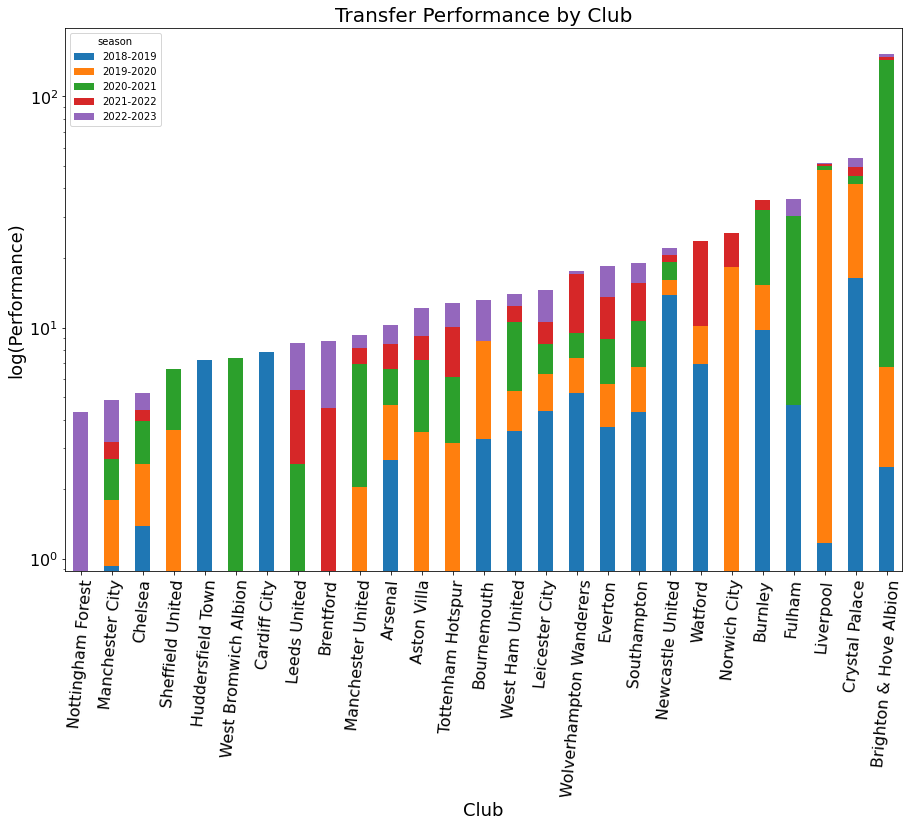

In [60]:
alt_df = team_df.groupby(['club', 'season'])['Score per eur'].sum().unstack('season')
alt_df['Sum'] = alt_df.sum(axis = 1)
alt_df = alt_df.sort_values(by = 'Sum')
alt_df.drop(columns = 'Sum', inplace = True)

alt_df.plot(kind = 'bar', stacked = True, logy = True,
            figsize = (15, 10), fontsize = 16, rot = 85,
            title = 'Transfer Performance by Club', xlabel = 'Club', ylabel = 'log(Performance)')
plt.gca().title.set_fontsize(20)
plt.gca().xaxis.label.set_fontsize(18)
plt.gca().yaxis.label.set_fontsize(18)

### Getting Team Percentage of Score from Transfers

In [ ]:
# Graph these on a stacked bar chart (teams on X axis) and years are the different bars

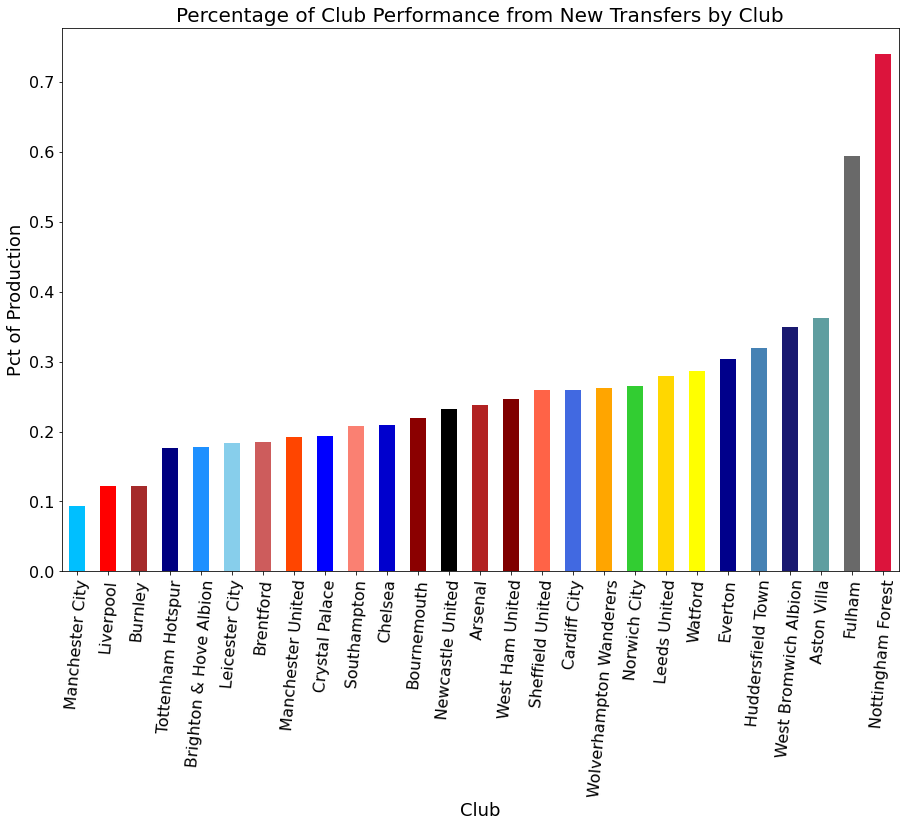

In [73]:
plt.clf()
pct_of_score = round((team_df['Transfer Score'] / team_df['Season Score']), 2)
team_df['Pct of Score'] = pct_of_score
colors = ['deepskyblue', 'red', 'brown', 'navy', 'dodgerblue', 'skyblue', 'indianred', 'orangered', 'blue', 'salmon',
         'mediumblue', 'darkred', 'black', 'firebrick', 'maroon', 'tomato', 'royalblue', 'orange', 'limegreen', 'gold',
         'yellow', 'darkblue', 'steelblue', 'midnightblue', 'cadetblue', 'dimgray', 'crimson']
team_df.groupby('club')['Pct of Score'].mean().sort_values().plot(kind = 'bar', 
                                                                  figsize = (15, 10), fontsize = 16, rot = 85,
                                                                  ylabel = 'Pct of Production', xlabel = 'Club',
                                                                 title = 'Percentage of Club Performance from New Transfers by Club',
                                                                 color = colors)
plt.gca().title.set_fontsize(20)
plt.gca().xaxis.label.set_fontsize(18)
plt.gca().yaxis.label.set_fontsize(18)